# 03_baseline_models



In [1]:
import os
import sys
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.scale import scale_features, sigmoid, log_plus_one
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred
from src.visualize import plot_bdgt_sched_scaled

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [7]:
category_values = data['Category'].value_counts()
category_names = category_values.index

print(category_values)
print('\n')
for name in category_names:
    print(name.upper())
    print()
    for project in data.loc[data['Category']==name]['Project_Name']:
        print(project)
    print('\n')

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Water Supply                          13
Wastewater Treatment                  13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Health and Hospitals                   3
Ferries                                3
Arts and Culture                       2
Parks                                  2
Industrial Development, Parks          1
Parks, Streets and Roadways            1
Name: Category, dtype: int64


STREETS AND ROADWAYS

Bergen Avenue Street Reconstruction
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
Battery Park Underpass Sandy Flood Damage Repair
Gansevoort Area Roadway Reconstruction
Woodhaven Blvd SBS


In [8]:
magency_values = data['Managing_Agency'].value_counts()
magency_names = magency_values.index

print(magency_values)
print('\n')
for name in magency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Managing_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DCAS     2
DSNY     2
Name: Managing_Agency, dtype: int64


DDC

Bergen Avenue Street Reconstruction
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
West 59th Street Marine Transfer Station Construction, Phase 2
Flatbush Avenue Trunk Watermain Replacement
Fresh Creek Basin Sewers Construction, Phase II
Baisley Boulevard Sewers and Watermain Construction
Fresh Creek Basin Sewers Construction, Phase III
2nd Avenue Watermain Trunk Construction
Francis Lewis Boulevard Construction
Fresh Creek Basin Sewers Construction, Phase I
Gansevoort Area Roadway Reconstruction
Hudson Yards Cultural Shed Facility New Construction
20th Avenue Storm and Sanitary Sewer Construction
Bainbridge Avenue Trunk Water Main
Ped Safety Upgrades on Atlantic Avenue

In [9]:
cagency_values = data['Client_Agency'].value_counts()
cagency_names = cagency_values.index

print(cagency_values)
print('\n')
for name in cagency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Client_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
H+H                     3
DPR                     3
DCLA                    2
DOHMH, HHC              1
DOT, Mayor's Office     1
ORR                     1
Mayor's Office          1
EDC                     1
DHS                     1
NYPD                    1
BWS                     1
DEP, EDC                1
DSBS                    1
Name: Client_Agency, dtype: int64


DEP

26th Ward Waste Water Treatment Plant Preliminary Treatment Improvements
Bowery Bay Waste Water Treatment Plant Main Sewage Pump Controls and Piping Replacements
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Wards Island Water Pollution Control Plant final Settling Tank Rehabilitation
Hannah Street Pumping Station Construction
Coney Island Biological Nutrient Constru

In [10]:
borough_values = data['Borough'].value_counts()
borough_names = borough_values.index

print(borough_values)
print('\n')
for name in borough_names:
    print(name.upper())
    print()
    for project in data.loc[data['Borough']==name]['Project_Name']:
        print(project)
    print('\n')

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
Valhalla                            2
New York                            2
Brooklyn, Queens                    1
Port Jervis                         1
Olive                               1
Marlboro                            1
Manhattan, Bronx                    1
Manhattan, Staten Island, Bronx     1
Name: Borough, dtype: int64


NOT_SPECIFIED

New Ferry Boat Construction
Woodhaven Blvd SBS
Grand Concourse, Phase 3
Grand Concourse Reconstruction, Phase 4 (Great Streets)
Queens Boulevard Reconstruction (Great Streets)
Hunters Point Street Reconstruction (Long Island City)
Brookville-Edgewood Triangle Reconstruction
FDR Rehabilitation, Northbound (East 42nd to 49th Streets)
Ped Safety Upgrades on Atlantic Avenue, Phase 2
Hen

## Subset and scale data for X and y frames

In [7]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [8]:
X, y = data[X_cols], data[y_cols]

In [9]:
random_state = 0
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [10]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t\t{}'.format(X_test.shape, y_test.shape))

(134, 2)	(134, 2)
(15, 2)		(15, 2)


In [11]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify columns to exclude from scaling (i.e. binary columns not to be scaled)
exclude_scale_cols = []

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None

X_train_stdz, Scaler_stdz = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz, Scaler_stdz = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

# Perform standard scaling and then pass through sigmoid transformation
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid

X_train_stdz_sig, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = None

X_train_norm, Scaler_norm = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_norm, Scaler_norm = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling then add 1 and perform log transformation and renormalize
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = log_plus_one
reapply_scaler = True

X_train_norm_log, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_norm_log, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust' scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = RobustScaler
scale_before_func = None
scale_after_func = None

X_train_rob, Scaler_rob = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_rob, Scaler_rob = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)



## Define functions for fitting and evaluating models

In [17]:
sm_formulas = [
    'Budget_Start + Duration_Start + Budget_Start * Duration_Start',
    'Budget_Start + Duration_Start'
]

model_descr = 'Linear regression with budget change ratio interaction'

model_LR_norm_log = generate_model_dict(
    sm.ols,
    model_descr,
    X_train, X_test, y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas
)

print_model_results(model_LR_norm_log)


MODEL SUMMARY:
Linear regression with budget change ratio interaction


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Budget_Start * Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0113
		Test		-1.4328

	Schedule_Change_Ratio

		Training	0.1997
		Test		0.2920





In [18]:
model_dict_test = generate_model_dict(LinearRegression, model_descr, X_train, X_test, y_train, y_test,
                    multioutput=True, verbose=False,
                    predictions=True, scores=True, model_api='sklearn')

print_model_results(model_dict_test)


MODEL SUMMARY:
Linear regression with budget change ratio interaction


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0045
		Test		-1.2832

	Schedule_Change_Ratio

		Training	0.1997
		Test		0.2920





## Define plotting functions to inspect scaled input data and regression results

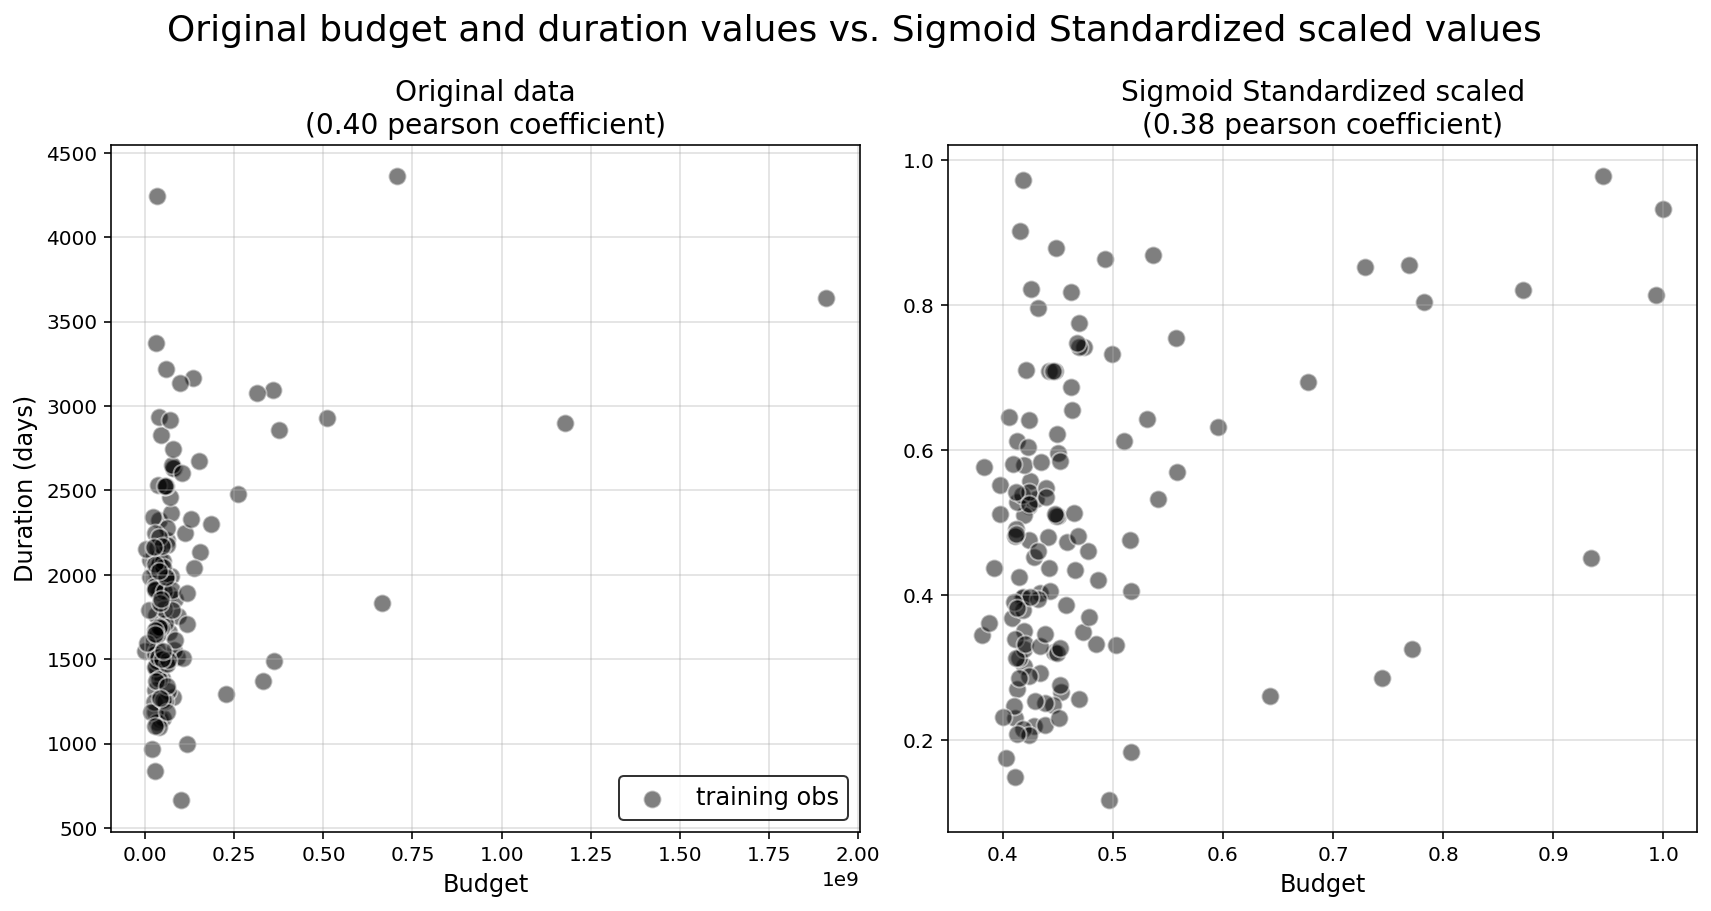

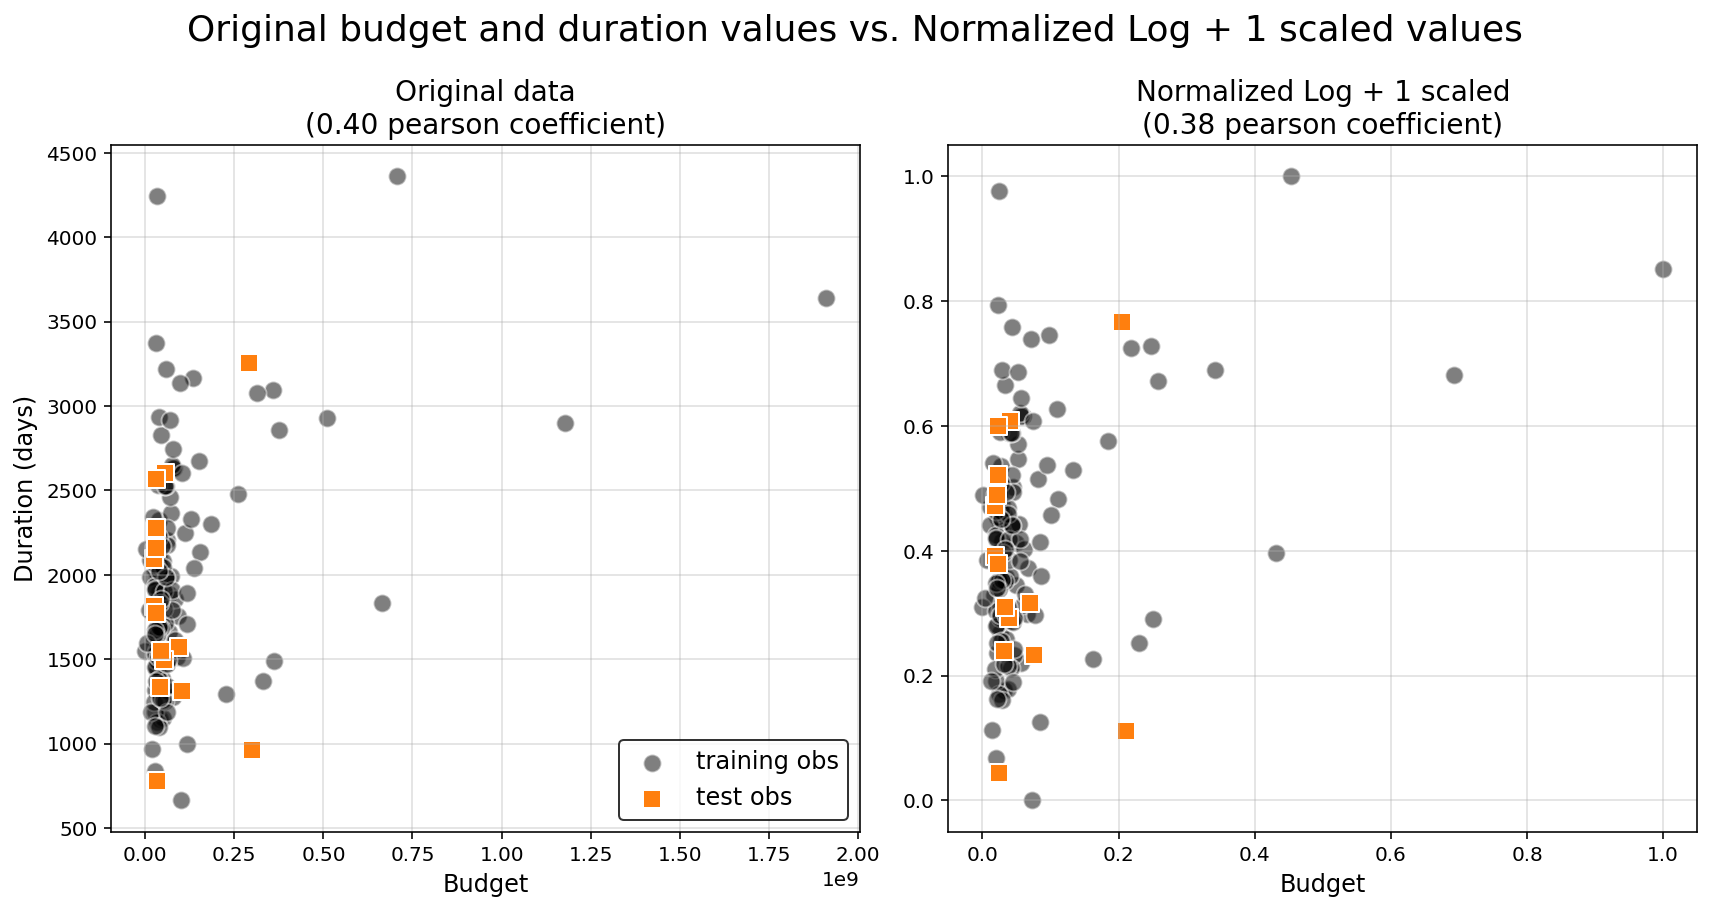

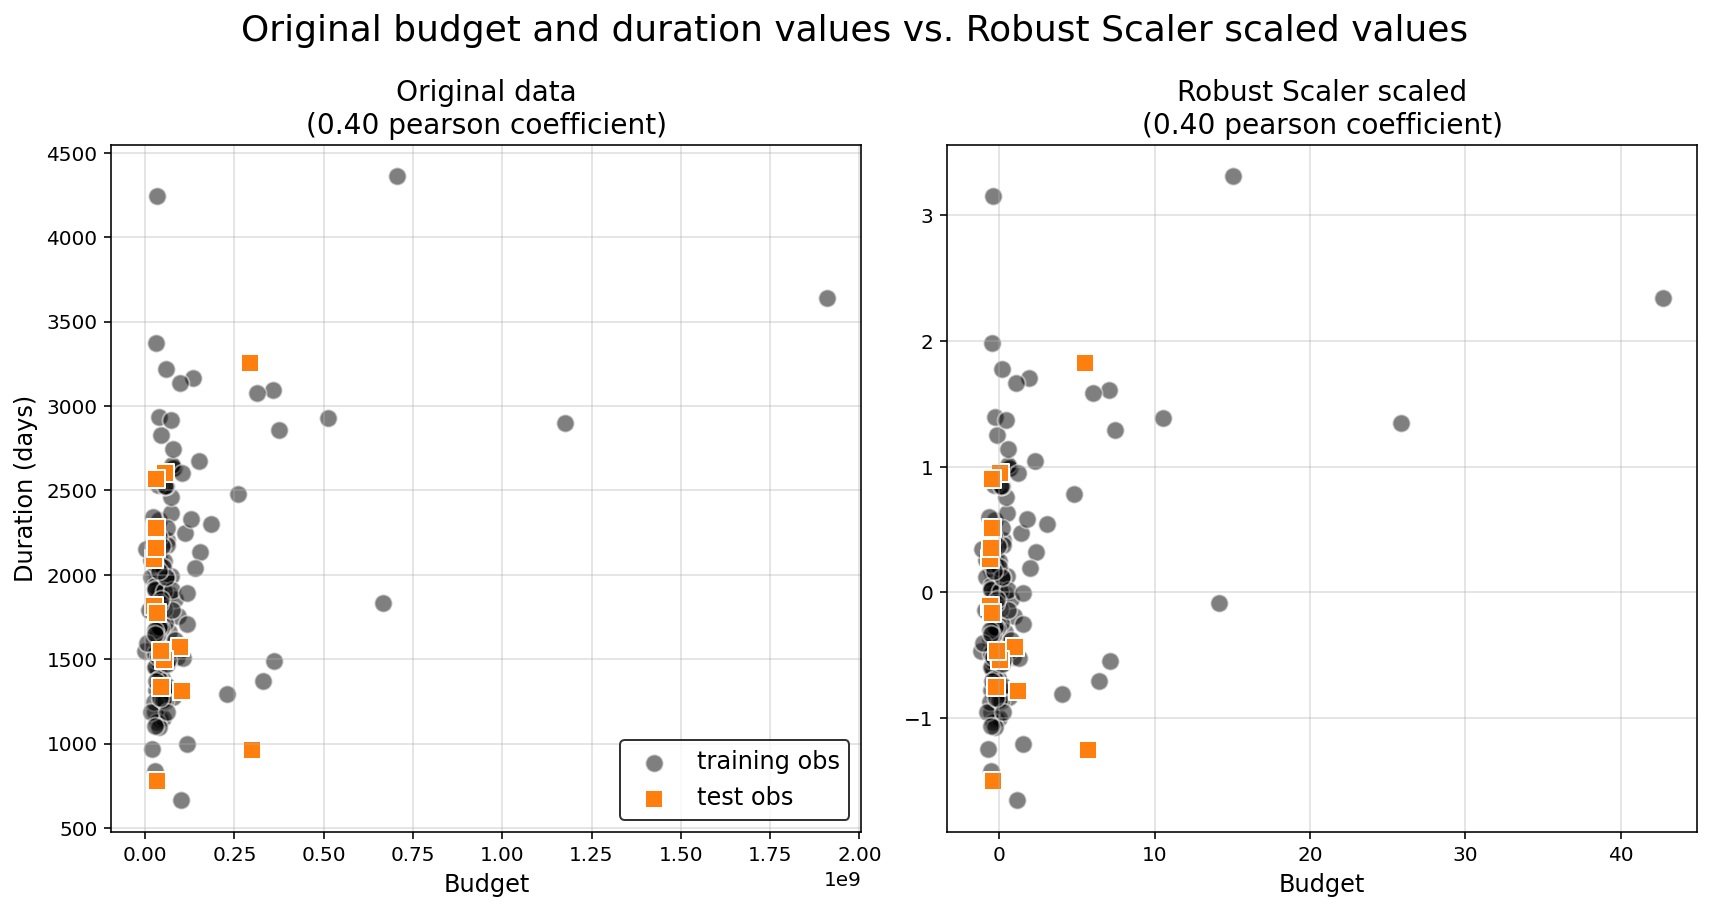

In [19]:
plot_bdgt_sched_scaled(X_train, X_train_stdz_sig, 'Sigmoid Standardized')
plot_bdgt_sched_scaled(X_train, X_train_norm_log, 'Normalized Log + 1', X_test, X_test_norm_log)
plot_bdgt_sched_scaled(X_train, X_train_rob, 'Robust Scaler', X_test, X_test_rob)

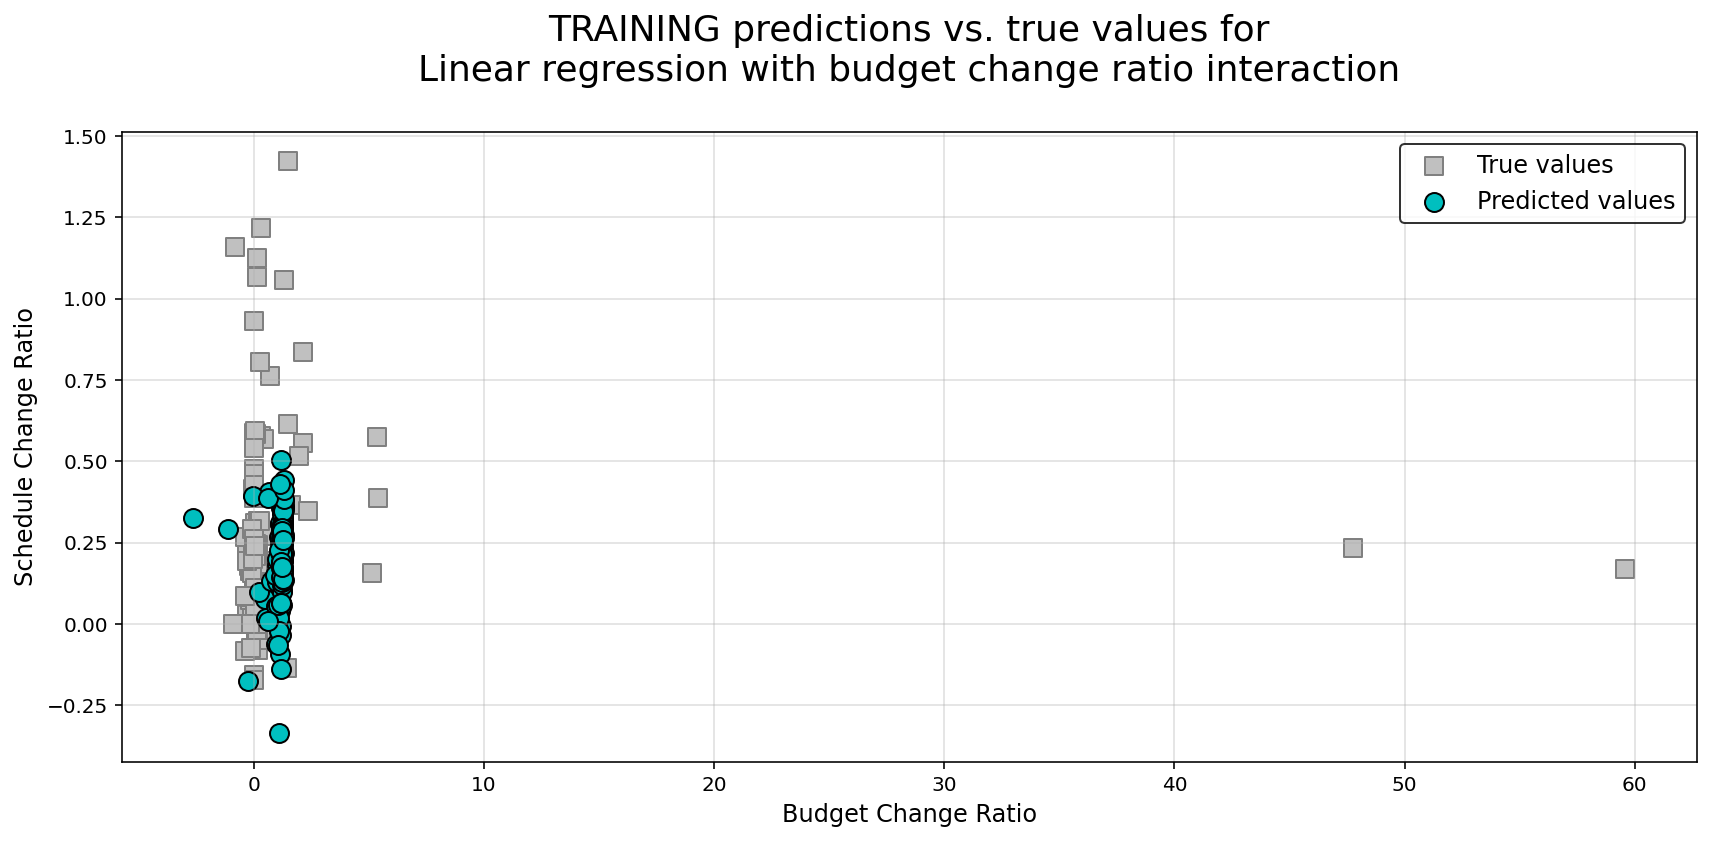

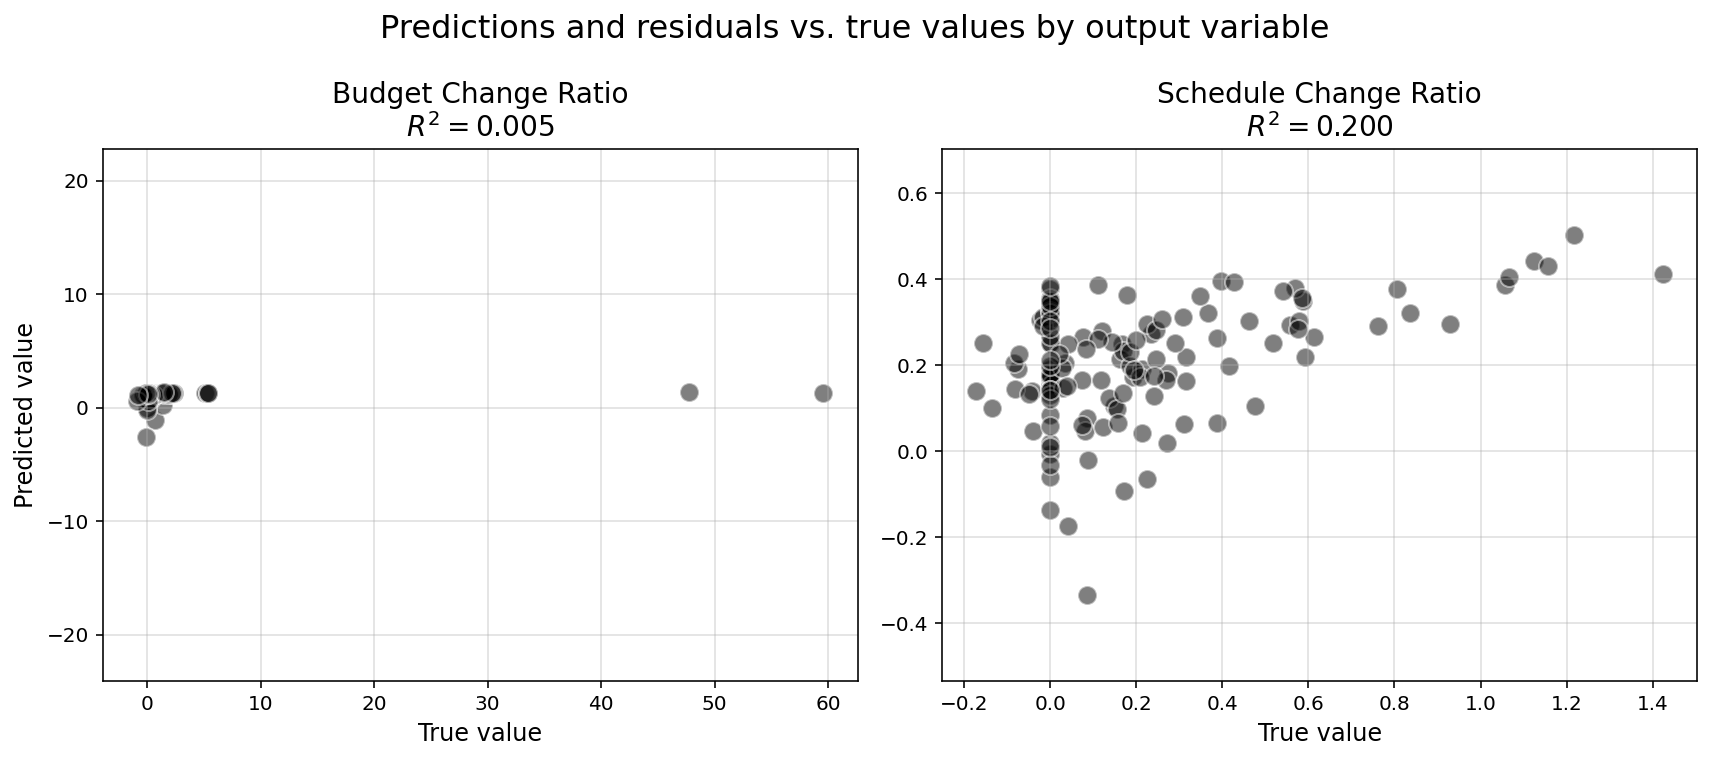

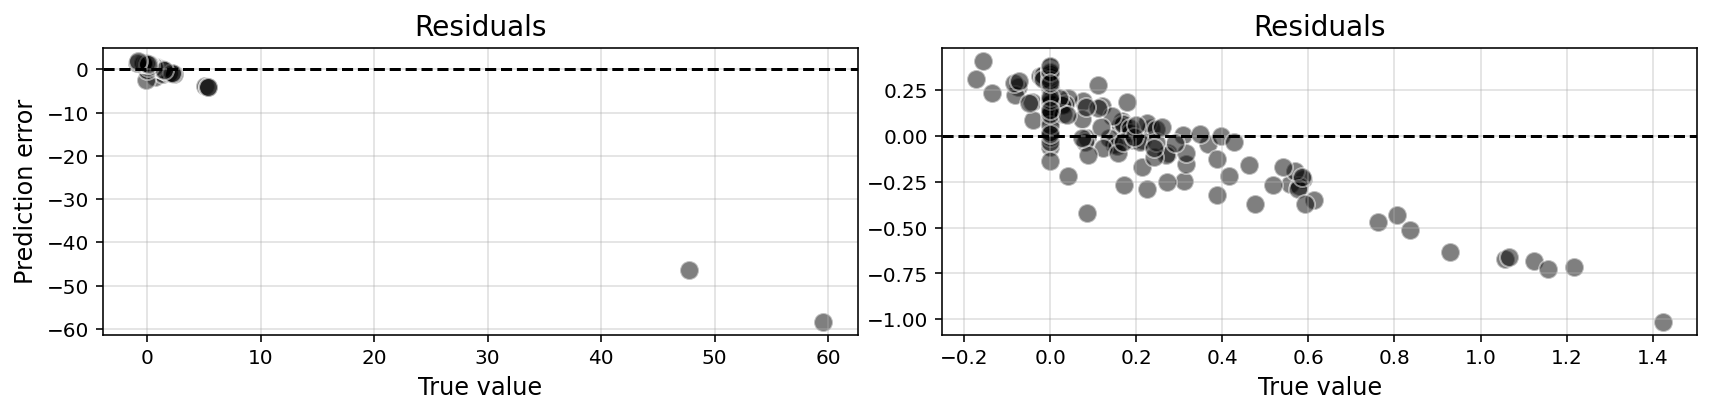

In [21]:
model_descr = 'linear regression with normalized log+1 data linear regression with normalized'
plot_true_pred(model_dict=model_dict_test, dataset='train')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

In [30]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Record_ID                2095 non-null   object 
 1   Date_Reported_As_Of      2095 non-null   object 
 2   PID                      2095 non-null   int64  
 3   Project_Name             2095 non-null   object 
 4   Description              2095 non-null   object 
 5   Category                 2095 non-null   object 
 6   Borough                  2095 non-null   object 
 7   Managing_Agency          2095 non-null   object 
 8   Client_Agency            2095 non-null   object 
 9   Current_Phase            2095 non-null   object 
 10  Design_Start             2095 non-null   object 
 11  Original_Budget          2095 non-null   float64
 12  Budget_Forecast          2095 non-null   float64
 13  Latest_Budget_Changes    2095 non-null   float64
 14  Total_Budget_Changes    

In [64]:
def plot_change_trend(trend_data, pid_data, pid, interval=None):
    """Plots 4 subplots showing project budget and duration forecast change trend
    """
    # sets default for converting datetimes in matplotlib
    from pandas.plotting import register_matplotlib_converters
    from matplotlib.dates import YearLocator, DateFormatter
    register_matplotlib_converters()
    
    years = YearLocator()
    years_fmt = DateFormatter('%Y')
     
    def set_date_axis(ax, years, years_fmt):
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
    
    # set sup_title reference fontsize
    fs=16

    # subset project record data (results from data generator)
    pid_record = pid_data.copy().loc[pid_data['PID']==pid]
    
    # subset project changes data (clean original dataset)
    changes_loc = (trend_data['PID']==pid) & (trend_data['Change_Year']<=interval) \
                  if interval else trend_data['PID']==pid
    pid_changes = trend_data.copy().loc[changes_loc]
    
    # convert datetime field to correct data type
    pid_changes['Date_Reported_As_Of'] = pd.to_datetime(pid_changes['Date_Reported_As_Of'])

    # calculate project duration array
    project_duration = pid_record['Duration_Start'].values[0] + \
                       np.cumsum(pid_changes['Latest_Schedule_Changes'].values)

    # generate subplots
    fig, ax = plt.subplots(2,2, sharex=True, figsize=(12,6))
    
    plt.suptitle(
        'PID {}:\n{}\nCategory: {}\nBorough: {}\Original Budget: \${:.2f} million\n'\
        'Original Duration: {:,.0f} days'.format(
            pid,
            pid_record['Project_Name'].values[0][:72],
            pid_record['Category'].values[0],
            pid_record['Borough'].values[0],
            pid_record['Budget_Start'].values[0]/1e7,
            pid_record['Duration_Start'].values[0]
        ), fontsize=fs, y=1.25
    )

    # plot budget forecast
    ax[0,0].plot(
        pid_changes['Date_Reported_As_Of'], pid_changes['Budget_Forecast']/1e7, 'ko-'
    )
    ax[0,0].axhline(
        pid_record['Budget_Start'].values[0]/1e7, color='k', linestyle=':',
        label='Original forecasted'
    )
    ax[0,0].set_title('Total budget forecast', fontsize=fs-2)
    ax[0,0].set_ylabel('USD (millions)', fontsize=fs-4)
    ax[0,0].legend(edgecolor='k', fontsize=fs-6)

    # plot budget forecast percent change
    ax[1,0].plot(
        pid_changes['Date_Reported_As_Of'],
        ((pid_changes['Latest_Budget_Changes'])/
        (pid_changes['Budget_Forecast']-pid_changes['Latest_Budget_Changes']))*100,
        'ko-'
    )
    ax[1,0].axhline(0, color='gray', linestyle='-', alpha=0.4)
    ax[1,0].set_title('Percentage budget change', fontsize=fs-2)
    ax[1,0].set_ylabel('percent change', fontsize=fs-4)

    ax[1,0].set_xlabel('project change date', fontsize=fs-4)

    # plot duration forecast
    ax[0,1].plot(
        pid_changes['Date_Reported_As_Of'], project_duration/1e3, 'ko-'
    )
    ax[0,1].axhline(
        pid_record['Duration_Start'].values[0]/1e3, color='k', linestyle=':',
    )
    ax[0,1].set_title('Total forecasted project duration', fontsize=fs-2)
    ax[0,1].set_ylabel('days (thousands)', fontsize=fs-4)

    # plot duration change
    ax[1,1].plot(
        pid_changes['Date_Reported_As_Of'],
        (pid_changes['Latest_Schedule_Changes'] /
        (project_duration - pid_changes['Latest_Schedule_Changes']))*100,
        'ko-'
    )
    ax[1,1].axhline(0, color='gray', linestyle='-', alpha=0.4)
    ax[1,1].set_title('Percentage duration change', fontsize=fs-2)
    ax[1,1].set_ylabel('percent change', fontsize=fs-4)
    
    ax[1,1].set_xlabel('project change date', fontsize=fs-4)
    
    for a in ax.flat:
        a.grid(':', alpha=0.4)
        set_date_axis(a, years, years_fmt)
    
    plt.tight_layout()
    plt.show()


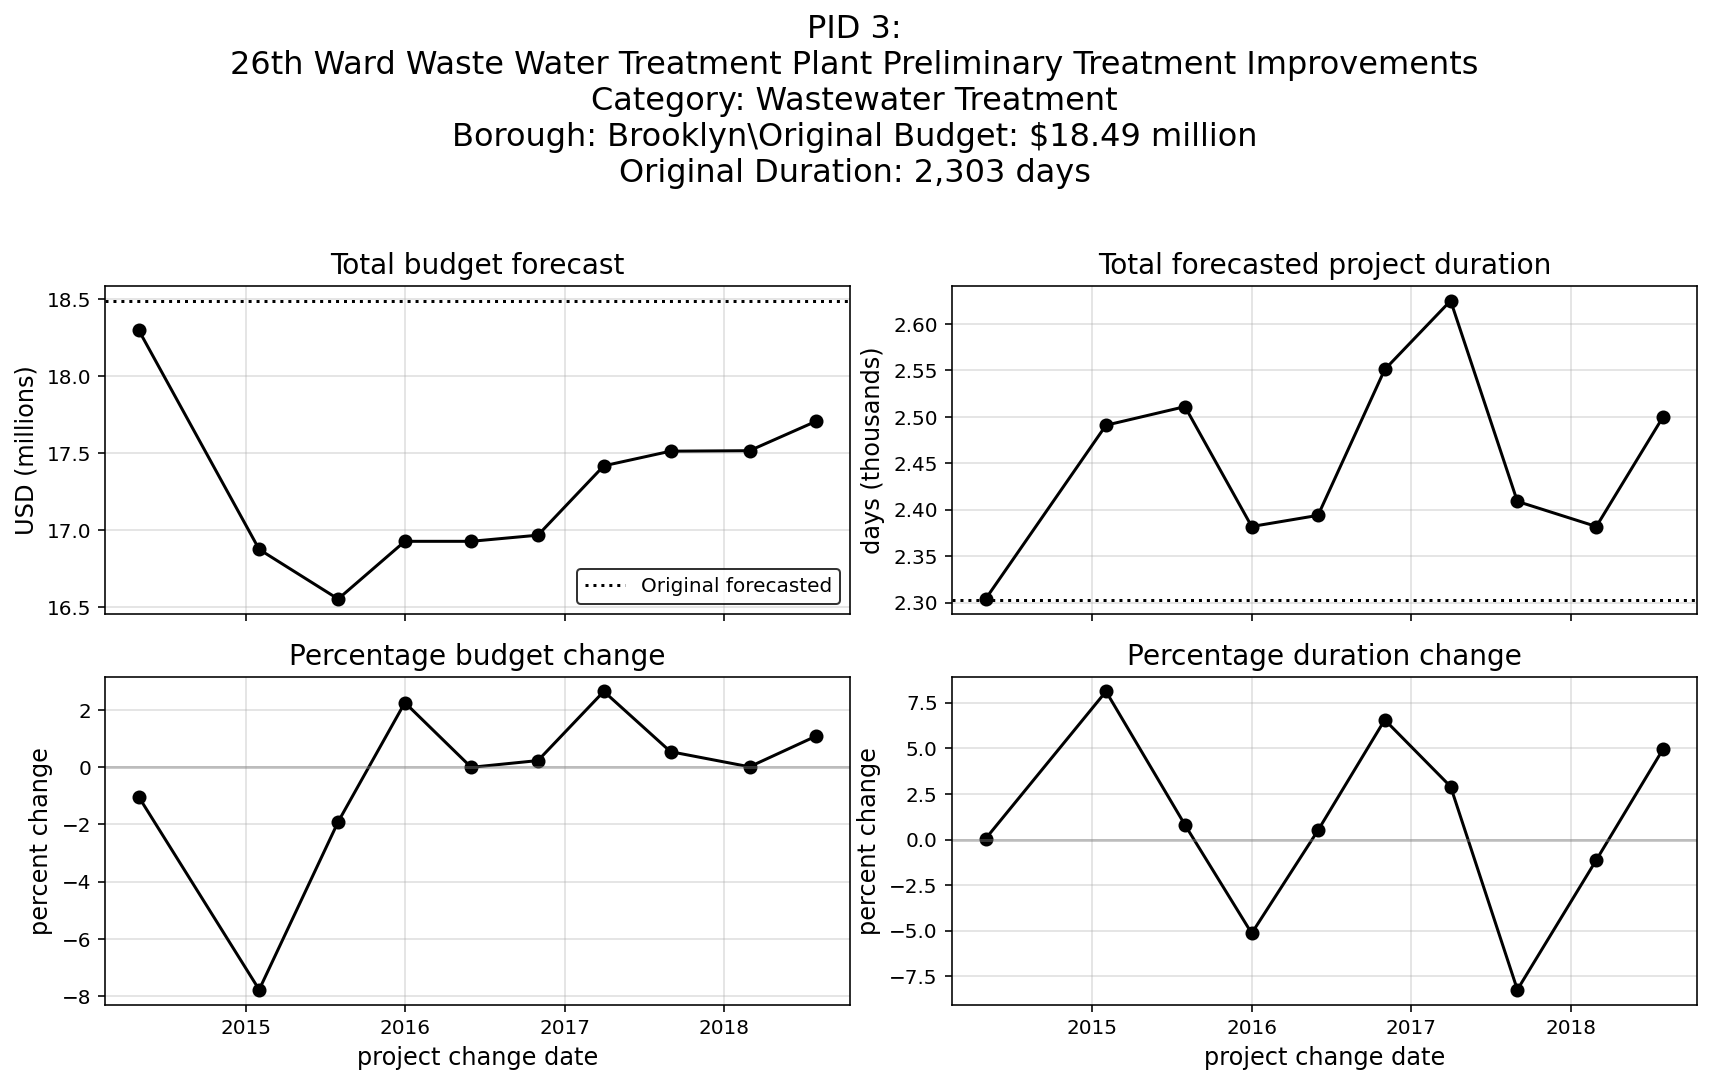

In [66]:
plot_change_trend(data_full, data, 3, 5)

In [14]:
(2.5-2.3)/2.3

0.08695652173913052